# UNC Best Practices (HG19) and UCSC CGL (HG38) RSEM Comparisons
A quick ipython notebook to ascertain the similarity between data produced by the UNC best practices RNA-seq pipeline and UCSC CGL's simplified RNA-seq pipeline (STAR -> RSEM, HG38), which is 80%+ faster. 

Author: John Vivian, jtvivian@gmail.com 
Date: 11-30-15

In [675]:
%matplotlib inline
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

In [676]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## I. Pre-Processing
### Pull in gene mapping file
CGL's newest RNA-seq pipeline uses the most current human reference genome (HG38) and Gencode's latest annotations (v23), which means all of the gene names have Gencode identifiers, whereas the UNC pipeline uses UCSC gene names.  We'll use a file that maps these gencode IDs to UCSC gene names. 

In [677]:
id_map = pd.read_table('attrs.tsv', sep='\t')

In [678]:
id_map.head()

,geneId,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000456328.2,DDX11L1-002,processed_transcript,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000362751.1,NaN,2,pseudo
1,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000450305.2,DDX11L1-001,transcribed_unprocessed_pseudogene,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000002844.2,NaN,2,pseudo
2,ENSG00000227232.5,WASH7P,unprocessed_pseudogene,KNOWN,ENST00000488147.1,WASH7P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000000958.1,OTTHUMT00000002839.1,NaN,2,pseudo
3,ENSG00000278267.1,MIR6859-1,miRNA,KNOWN,ENST00000619216.1,MIR6859-1-201,miRNA,KNOWN,NaN,NaN,NaN,3,nonCoding
4,ENSG00000243485.3,RP11-34P13.3,lincRNA,KNOWN,ENST00000473358.1,RP11-34P13.3-001,lincRNA,KNOWN,OTTHUMG00000000959.2,OTTHUMT00000002840.1,NaN,2,nonCoding


### Create dictionary mapping geneID to geneName

In [679]:
gene_mappings = {x: y for x, y in itertools.izip(id_map['geneId'], id_map['geneName'])}
isoform_mappings = {x: y for x, y in itertools.izip(id_map['transcriptId'], id_map['transcriptName'])}

### Read in TPM files as data frames
Our RSEM results are parsed into several files, most importantly being the Transcripts per Million (TPM) for both genes and isoforms.

In [680]:
cgl_genes = pd.read_table('CGL.genes.norm_tpm.tab', sep='\t')
cgl_isoforms = pd.read_table('CGL.isoform.norm_tpm.tab', sep='\t')
unc_genes = pd.read_table('UNC.genes.norm_tpm.tab', sep='\t')

### Quick look at each dataframe

In [681]:
cgl_genes.head()

,gene_id,test_SRR1559191
0,ENSG00000000003.14,1223.3429
1,ENSG00000000005.5,0.0000
2,ENSG00000000419.12,1747.1182
3,ENSG00000000457.13,174.3516
4,ENSG00000000460.16,128.9625


In [682]:
unc_genes.head()

,gene_id,test_unc_SRR1559191
0,A1BG,115.3894
1,A1CF,0.0000
2,A2BP1,468.2432
3,A2LD1,48.7805
4,A2ML1,0.0000


In [683]:
cgl_isoforms.head()

,gene_id/transcript_id,test_SRR1559191
0,ENSG00000000003.14/ENST00000373020.8,2263.0029
1,ENSG00000000003.14/ENST00000494424.1,0.0000
2,ENSG00000000003.14/ENST00000496771.5,751.7174
3,ENSG00000000003.14/ENST00000612152.4,317.9588
4,ENSG00000000003.14/ENST00000614008.4,0.0000


### Replace CGL geneIDs with geneNames

In [684]:
gene_names = []
keyerrors = 0.0
for gene_id in cgl_genes['gene_id']:
    try:    
        gene_names.append(gene_mappings[gene_id])
    except KeyError:
        keyerrors += 1
        gene_names.append(gene_id)
print "Number of unmapped genes: {}, of {} total genes.".format(keyerrors, len(cgl_genes['gene_id']))
print "{}% of genes succesfully mapped.".format(100*round(1-(keyerrors/len(cgl_genes['gene_id'])),4))

Number of unmapped genes: 50.0, of 60498 total genes.
99.92% of genes succesfully mapped.


### Replace CGL transcriptIDs with transcriptNames

In [685]:
isoform_names = []
keyerrors = 0.0
for transcript_id in cgl_isoforms['gene_id/transcript_id']:
    try:    
        isoform_names.append(isoform_mappings[transcript_id.split('/')[1]])
    except KeyError:
        keyerrors += 1
        isoform_names.append(gene_id)
print "Number of unmapped isoforms: {}, of {} total genes.".format(keyerrors, len(cgl_isoforms['gene_id/transcript_id']))
print "{}% of isoforms succesfully mapped.".format(100*round(1-(keyerrors/len(cgl_isoforms['gene_id/transcript_id'])),4))

Number of unmapped isoforms: 164.0, of 198619 total genes.
99.92% of isoforms succesfully mapped.


In [686]:
cgl_genes['gene_id'] = gene_names
cgl_isoforms['gene_id/transcript_id'] = isoform_names

## II. Gene Analysis

In [687]:
cgl_genes.columns = ['id', 'count']
unc_genes.columns = ['id', 'count']
cgl_isoforms.columns = ['id', 'count']

In [688]:
cgl_genes.head()

,id,count
0,TSPAN6,1223.3429
1,TNMD,0.0000
2,DPM1,1747.1182
3,SCYL3,174.3516
4,C1orf112,128.9625


In [689]:
unc_genes.head()

,id,count
0,A1BG,115.3894
1,A1CF,0.0000
2,A2BP1,468.2432
3,A2LD1,48.7805
4,A2ML1,0.0000


### Filter Dataframes by Genes in Both Sets

In [690]:
cgl_ids = set(cgl_genes['id'])
unc_ids = set(unc_genes['id'])

In [691]:
intersection_of_genes = cgl_ids & unc_ids
print 'Length of (gene) intersection: {}'.format(len(intersection_of_genes))
print 'Number of genes in cgl: {}'.format(len(cgl_ids))
print 'Number of genes in UNC: {}'.format(len(unc_ids))

Length of (gene) intersection: 18213
Number of genes in cgl: 58631
Number of genes in UNC: 20500


The HG38 assembly contains 261 alt loci, many of which are associated with the LRC/KIR area of chr19 and the MHC region on chr6, which causes the disparity in gene size between the two files. 

In [692]:
filtered_cgl = cgl_genes[cgl_genes['id'].isin(intersection_of_genes)].drop_duplicates('id').sort('id')
filtered_unc = unc_genes[unc_genes['id'].isin(intersection_of_genes)].sort('id')

assert len(intersection_of_genes) == len(filtered_cgl) == len(filtered_unc)

In [693]:
filtered_cgl.head()

,id,count
5165,A1BG,505.7637
9113,A1CF,0.0000
13992,A2M,2792.5072
11892,A2ML1,0.0000
6004,A4GALT,88.9769


In [694]:
filtered_unc.head()

,id,count
0,A1BG,115.3894
1,A1CF,0.0000
5,A2M,3794.2305
4,A2ML1,0.0000
6,A4GALT,88.3992


### Gene Plot

In [695]:
filtered_cgl['x'] = [x for x in range(len(filtered_cgl))]
filtered_unc['x'] = [x for x in range(len(filtered_unc))]

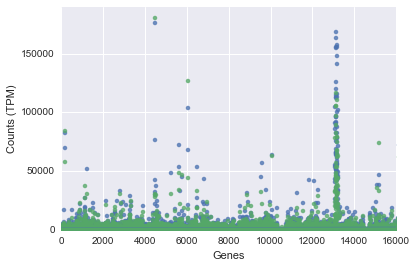

In [696]:
sns.regplot(x='x', y='count', data=filtered_cgl)
ax = sns.regplot(x='x', y='count', data=filtered_unc);
ax.axes.set_xlim([0,16000])
ax.axes.set_ylim([0,190000]);
ax.set(xlabel='Genes', ylabel='Counts (TPM)');

Overlaying the two dataframes as counts against genes provides us a rough idea of their similarity, but isn't the best way to present this data if we're trying to compare how similar they are.

Given the disparity between expression values (some close to 0, others close to 200,000), we'll plot the logs of the counts against each other. So the first step is to remove all genes with expression values equal to 0, as they'll be undefined in log space.

In [697]:
filtered_cgl = filtered_cgl[filtered_cgl['count'] != 0]
filtered_unc = filtered_unc[filtered_unc['count'] != 0]

Filter the sets again by intersection.

In [698]:
intersection_of_genes = set(filtered_cgl['id']) & set(filtered_unc['id'])
filtered_cgl = cgl_genes[cgl_genes['id'].isin(intersection_of_genes)].drop_duplicates('id').sort('id')
filtered_unc = unc_genes[unc_genes['id'].isin(intersection_of_genes)].sort('id')
assert len(intersection_of_genes) == len(filtered_cgl) == len(filtered_unc)

Reset the row indexes to avoid sorting errors when assembling a new dataframe and take the log of the counts.

In [699]:
filtered_cgl.reset_index(inplace=True)
filtered_unc.reset_index(inplace=True)
filtered_cgl['count'] = np.log(filtered_cgl['count'])
filtered_unc['count'] = np.log(filtered_unc['count'])

Create new dataframe that contains counts from both sets

In [700]:
gene_master = pd.DataFrame()
gene_master['genes'] = filtered_cgl['id']
gene_master['cgl'] = filtered_cgl['count']
gene_master['unc'] = filtered_unc['count']

In [701]:
gene_master.head()

,genes,cgl,unc
0,A1BG,6.226070,4.748312
1,A2M,7.934695,8.241237
2,A4GALT,4.488377,4.481863
3,AAAS,7.504349,6.956209
4,AACS,6.487228,6.504763


Pearson Correlation Coefficient is a measure of the linear correlation between two variables X and Y, giving a value between +1 and −1 inclusive, where 1 is total positive correlation, 0 is no correlation, and −1 is total negative correlation.

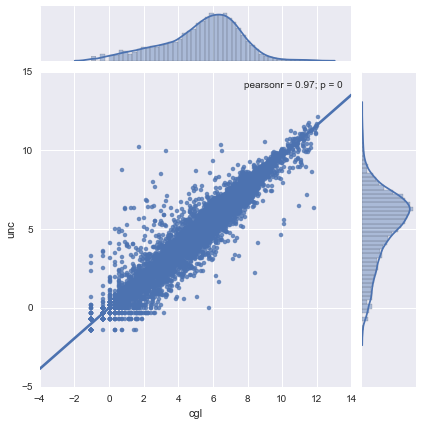

In [702]:
sns.jointplot(x='cgl', y='unc', data=gene_master, kind='reg');

Beautiful. This is pretty much exactly what we would expect to see if the two datasets were extremely similar.

## III. Isoform Analysis
Since the annotations used between pipelines are different, isoform comparisons wouldn't really make much sense.

## IV. Kallisto and RSEM Similarity Comparison
While the CGL version of the RNA-seq pipeline runs 80%+ faster than the old one, Kallisto can be perform quantification before STAR is even finished with alignment, while using fewer resources.  RSEM isn't known for its stellar transcript-level quantification, but it'll be interesting to see how they compare.

In [703]:
kallisto = pd.read_table('kallisto_SRR1559191.abundance.tsv', sep='\t')
kallisto.columns = ['id', 'length', 'est_length', 'est_counts', 'tpm']

In [704]:
kallisto.head()

,id,length,est_length,est_counts,tpm
0,ENST00000619216.1,68,27.6748,20.434000,22.740800
1,ENST00000473358.1,712,543.4470,5.043420,0.285829
2,ENST00000469289.1,535,366.6550,0.000000,0.000000
3,ENST00000607096.1,138,18.2009,0.000000,0.000000
4,ENST00000417324.1,1187,1018.4500,0.004311,0.000130


### Replace Gencode IDs in Kallisto Dataframe with TranscriptNames

In [705]:
isoform_names = []
keyerrors = 0.0
for transcript_id in kallisto['id']:
    try:    
        isoform_names.append(isoform_mappings[transcript_id])
    except KeyError:
        keyerrors += 1
        isoform_names.append(gene_id)
print "Number of unmapped isoforms: {}, of {} total genes.".format(keyerrors, len(kallisto['id']))
print "{}% of isoforms succesfully mapped.".format(100*round(1-(keyerrors/len(kallisto['id'])),4))

Number of unmapped isoforms: 0.0, of 197044 total genes.
100.0% of isoforms succesfully mapped.


In [706]:
kallisto['id'] = isoform_names

In [707]:
kallisto.head()

,id,length,est_length,est_counts,tpm
0,MIR6859-1-201,68,27.6748,20.434000,22.740800
1,RP11-34P13.3-001,712,543.4470,5.043420,0.285829
2,RP11-34P13.3-002,535,366.6550,0.000000,0.000000
3,MIR1302-2-201,138,18.2009,0.000000,0.000000
4,FAM138A-001,1187,1018.4500,0.004311,0.000130


### Find Intersection of Transcripts between CGL and Kallisto Sets

In [708]:
cgl_isoforms = cgl_isoforms[cgl_isoforms['count'] != 0]
kallisto = kallisto[kallisto['tpm'] != 0]

intersection_of_transcripts = set(kallisto['id']) & set(cgl_isoforms['id'])
filtered_cgl = cgl_isoforms[cgl_isoforms['id'].isin(intersection_of_transcripts)].drop_duplicates('id').sort('id')
filtered_kallisto = kallisto[kallisto['id'].isin(intersection_of_transcripts)].drop_duplicates('id').sort('id')

filtered_cgl.reset_index(inplace=True)
filtered_kallisto.reset_index(inplace=True)

assert len(intersection_of_transcripts) == len(filtered_cgl) == len(filtered_kallisto)
print "Number of Isoforms to analyze: {}".format(len(intersection_of_transcripts))

Number of Isoforms to analyze: 85887


In [709]:
filtered_kallisto.head()

,index,id,length,est_length,est_counts,tpm
0,99799,A1BG-002,2301,2132.450,27.9001,0.402963
1,99796,A1BG-003,2134,1965.450,76.0166,1.191200
2,99800,A1BG-005,475,306.964,128.8300,12.926100
3,99810,A1BG-AS1-001,2130,1961.450,34.5470,0.542465
4,99801,A1BG-AS1-002,1718,1549.450,73.3794,1.458600


In [710]:
filtered_cgl.head()

,index,id,count
0,46591,A1BG-002,38.2728
1,46592,A1BG-003,76.5456
2,46593,A1BG-005,1263.9843
3,188520,A1BG-AS1-001,61.8253
4,188519,A1BG-AS1-002,167.8116


In [711]:
isoform_master = pd.DataFrame()
isoform_master['id'] = filtered_kallisto['id']
isoform_master['kallisto'] = np.log(filtered_kallisto['est_counts'])
isoform_master['cgl'] = np.log(filtered_cgl['count'])

In [712]:
isoform_master.head()

,id,kallisto,cgl
0,A1BG-002,3.328630,3.644739
1,A1BG-003,4.330952,4.337887
2,A1BG-005,4.858494,7.142024
3,A1BG-AS1-001,3.542321,4.124313
4,A1BG-AS1-002,4.295643,5.122842


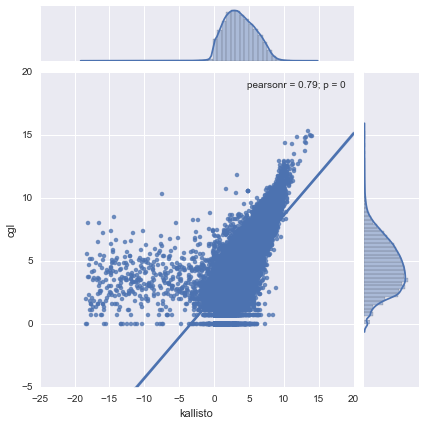

In [713]:
ax = sns.jointplot(x='kallisto', y='cgl', data=isoform_master, kind='reg', ylim=[-5,20]);

Not as tight of a regression pattern as we were hoping for.  It looks like Kallisto is much more sensitive about assigning count values that are lower than RSEMs (as count values less than one appear negative in log space).  I've also been told that RSEM isn't the most trusted tool to perform isoform-level quantificiation.

So what we'll do is map every kallisto transcript to the gene it is associated with, sum the counts, then compare gene level quantification between kallisto and RSEM.

### TranscriptID to GeneName mapping

In [714]:
transcript_to_gene = {x: y for x, y in itertools.izip(id_map['transcriptId'], id_map['geneName'])}

In [715]:
kallisto = pd.read_table('kallisto_SRR1559191.abundance.tsv', sep='\t')
kallisto.columns = ['id', 'length', 'est_length', 'est_counts', 'tpm']

In [716]:
gene_names = []
keyerrors = 0.0
for transcript_id in kallisto['id']:
    try:    
        gene_names.append(transcript_to_gene[transcript_id])
    except KeyError:
        keyerrors += 1
        gene_names.append(gene_id)
print "Number of unmapped isoforms: {}, of {} total genes.".format(keyerrors, len(kallisto['id']))
print "{}% of isoforms succesfully mapped.".format(100*round(1-(keyerrors/len(kallisto['id'])),4))

Number of unmapped isoforms: 0.0, of 197044 total genes.
100.0% of isoforms succesfully mapped.


In [717]:
kallisto['id'] = gene_names

In [718]:
kallisto = kallisto[kallisto['est_counts'] != 0]

In [719]:
kallisto = kallisto.sort('id')

In [720]:
kallisto_genes = pd.DataFrame()
kallisto_genes['id'] = kallisto['id'].drop_duplicates('id')
kallisto_genes['sum'] = kallisto.groupby('id')['est_counts'].transform('sum')

In [721]:
kallisto_genes.sort('id').head()

,id,sum
141183,5S_rRNA,9.297400
9216,7SK,1.756446
99799,A1BG,235.159000
99806,A1BG-AS1,120.360600
18043,A1CF,6.010370


In [722]:
cgl_genes = cgl_genes[cgl_genes['count'] != 0]

In [723]:
cgl_genes.sort('id').head()

,id,count
5165,A1BG,505.7637
52148,A1BG-AS1,95.8213
13992,A2M,2792.5072
38433,A2M-AS1,121.7579
44468,A2MP1,10.8069


### Find Intersection of Kallisto and RSEM Genes

In [724]:
intersection_of_genes = set(cgl_genes['id']) & set(kallisto_genes['id'])
filtered_cgl_genes = cgl_genes[cgl_genes['id'].isin(intersection_of_genes)].drop_duplicates('id').sort('id')
filtered_kallisto_genes = kallisto_genes[kallisto_genes['id'].isin(intersection_of_genes)].sort('id')

print 'Number of genes to compare: {}'.format(len(intersection_of_genes))
assert len(intersection_of_genes) == len(filtered_cgl_genes) == len(filtered_kallisto_genes);

Number of genes to compare: 25364


In [725]:
filtered_cgl_genes.reset_index(inplace=True)
filtered_kallisto_genes.reset_index(inplace=True)
filtered_cgl_genes['count'] = np.log(filtered_cgl_genes['count'])
filtered_kallisto_genes['sum'] = np.log(filtered_kallisto_genes['sum'])

In [726]:
gene_master = pd.DataFrame()
gene_master['genes'] = filtered_cgl_genes['id']
gene_master['rsem_gene'] = filtered_cgl_genes['count']
gene_master['kallisto_gene'] = filtered_kallisto_genes['sum']

In [727]:
gene_master.head()

,genes,rsem_gene,kallisto_gene
0,A1BG,6.226070,5.460262
1,A1BG-AS1,4.562485,4.790492
2,A2M,7.934695,8.846146
3,A2M-AS1,4.802035,5.349210
4,A3GALT2,0.365268,1.609438


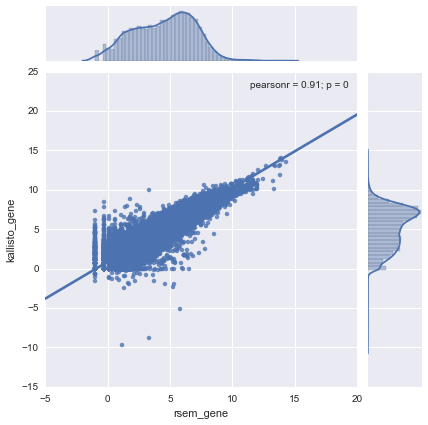

In [728]:
sns.jointplot(x='rsem_gene', y='kallisto_gene', data=gene_master, kind='reg');

Much better! These counts are produced by different algorithms, so we shouldn't expect perfect concordance. I'll defer to the [kallisto paper](http://arxiv.org/abs/1505.02710) to explain how one might compare the relative accuracy between these two methods.

If you find any errors or corrections please feel free to make a pull request or contact the author.  Feedback of any kind is appreciated.